<a href="https://colab.research.google.com/github/ozwin/Snake_Species_Recognition/blob/main/Models/ResNet34/ResNet34_15_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/15-classes.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done


In [2]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import pandas as pd

In [33]:
training_path = '/content/15-classes/train/'
test_path = '/content/15-classes/test'
val_path = '/content/15-classes/val'
def transformDS1( batchSize, inputSize):

    training_transforms = transforms.Compose([transforms.Resize((inputSize,inputSize)),transforms.ToTensor()])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform = training_transforms)
    train_Loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=batchSize,shuffle=False)

    mean, std = get_mean_std(train_Loader)

    train_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform=train_transforms)
    test_dataset = torchvision.datasets.ImageFolder(root=test_path,transform=test_transforms)
    val_dataset = torchvision.datasets.ImageFolder(root=val_path,transform=val_transforms)


    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)

    return data_loader_train,data_loader_test,data_loader_val

def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

def show_transformed_images(data_loader_train):
    batch=next(iter(data_loader_train))
    images,labels = batch
    grid = torchvision.utils.make_grid(images,nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.show()
    print("labels:",labels)

In [4]:
train_loader,test_loader,val_loader = transformDS1(32,224)

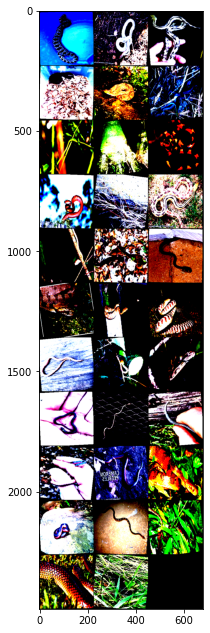

labels: tensor([ 1,  2,  9,  1, 14,  2,  5, 13,  7, 11,  8,  9, 12,  4, 11, 12, 12, 11,
         2, 12, 12, 10, 12,  2,  0,  0, 12,  0,  9, 14,  8,  8])


In [34]:
show_transformed_images(train_loader)

In [5]:
import torch.cuda


def set_device():
    if torch.cuda.is_available():
        device = "cuda:0"
    else:
        device = "cpu"
    return device

In [6]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    device = set_device()
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [60]:
resnet_34 = models.resnet34(pretrained=False)
num_classes = 15
device = set_device()
num_filters = resnet_34.fc.in_features
resnet_34.fc = nn.Linear(num_filters, num_classes)
resnet_34 = resnet_34.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_34.parameters(), lr=0.0002,momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0001)
epoch_count = 0
n_epochs = 100

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:

Accuracies = [] 
valAccuracies = []
valLoss = []
trainLoss = []
total_steps = len(train_loader)
t1 = time.time()
device = set_device()
validation_accuracy = 0
print("-----Device:"+device+"-----")
for epoch in range(n_epochs):
    print("Epoch number %d" %(epoch+1))
    resnet_34.train()
    running_loss = 0.0
    running_correct = 0.0
    val_loss = 0.0
    total = 0
    for i, data in enumerate(train_loader):
        images,labels = data
        device = set_device()
        images = images.to(device)
        labels = labels.to(device)
        total+=labels.size(0)

        optimizer.zero_grad()
        outputs = resnet_34(images)
        _,predicted = torch.max(outputs.data,1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
        running_correct += (labels==predicted).sum().item()
        if (i + 1) % 10 == 0:
          validation_accuracy = 0
          resnet_34.eval()
          with torch.no_grad(): 
              val_correct = 0
              val_total = 0
              val_loss = 0
              for data in val_loader:
                  images, val_labels = data[0].to(device), data[1].to(device)
                  images = images.to(device)
                  val_labels = val_labels.to(device)
                  outputs = resnet_34(images)
                  lossVal = criterion(outputs,val_labels)
                  val_loss += lossVal.item()
                  # Validation set accuracy
                  
                  _,predicted = torch.max(outputs.data, 1)
                  val_correct += (predicted == val_labels).sum().item()
                  val_total  += val_labels.size(0)
              
        validation_accuracy = (val_correct / val_total) *100
        training_accuracy = (running_correct / total) * 100
        # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%, Validation Loss: {:.2f}'
        #     .format(epoch + 1, n_epochs, i + 1, total_steps, loss.item(), training_accuracy , validation_accuracy,lossVal.item()))
    
    scheduler.step()
    
    epoch_loss = running_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    epoch_accuracy = 100.00 * running_correct/total
    Accuracies.append(epoch_accuracy)
    valAccuracies.append(validation_accuracy)
    trainLoss.append(epoch_loss)
    valLoss.append(val_loss)
    
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f"%(epoch_loss,epoch_accuracy,val_loss))

print("---Training finished in {} seconds---".format(time.time()-t1))
epoch_count+=n_epochs
torch.save(resnet_34.state_dict(), "/content/15-Class-"+str(epoch_count)+"-epoch.pt")

test_acc = evaluate_model(resnet_34,test_loader)
dict = {'Training': Accuracies, 'Validation': valAccuracies} 
dictLoss = {'Training': trainLoss,'Validation': valLoss}
df = pd.DataFrame(dict)
df2 = pd.DataFrame(dictLoss)
df.to_csv("/content/Accuracies"+str(epoch_count)+".csv")
df2.to_csv("/content/Loss"+str(epoch_count)+".csv")
from google.colab import files
files.download("/content/15-Class-"+str(epoch_count)+"-epoch.pt")
files.download("/content/Accuracies"+str(epoch_count)+".csv")
files.download("/content/Loss"+str(epoch_count)+".csv")

-----Device:cuda:0-----
Epoch number 1
Training Data: Epoch Loss: 2.670, Epoch Accuracy: 8.454, Validation Loss: 2.535
Epoch number 2
Training Data: Epoch Loss: 2.586, Epoch Accuracy: 10.870, Validation Loss: 2.511
Epoch number 3
Training Data: Epoch Loss: 2.541, Epoch Accuracy: 12.526, Validation Loss: 2.440
Epoch number 4
Training Data: Epoch Loss: 2.521, Epoch Accuracy: 14.217, Validation Loss: 2.454
Epoch number 5
Training Data: Epoch Loss: 2.473, Epoch Accuracy: 15.735, Validation Loss: 2.420
Epoch number 6
Training Data: Epoch Loss: 2.446, Epoch Accuracy: 15.597, Validation Loss: 2.450
Epoch number 7
Training Data: Epoch Loss: 2.439, Epoch Accuracy: 16.977, Validation Loss: 2.347
Epoch number 8
Training Data: Epoch Loss: 2.408, Epoch Accuracy: 17.564, Validation Loss: 2.304
Epoch number 9
Training Data: Epoch Loss: 2.373, Epoch Accuracy: 19.324, Validation Loss: 2.334
Epoch number 10
Training Data: Epoch Loss: 2.340, Epoch Accuracy: 20.428, Validation Loss: 2.334
Epoch number 11


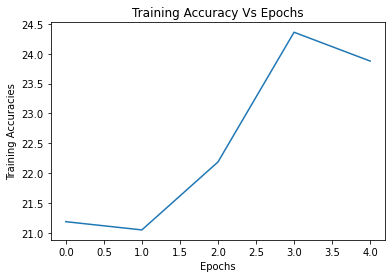

In [48]:
# Plotting Accuracies Vs Epochs
plt.plot(range(n_epochs),Accuracies)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracies")
plt.title("Training Accuracy Vs Epochs")
plt.show()

In [53]:
print(val_loss/len(val_loader))

18.075601634900433


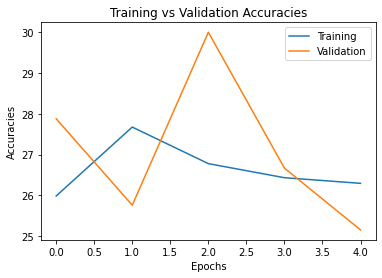

In [58]:
# Plotting Validation Accuracies Vs Train Accuracies on Epochs
plt.plot(range(n_epochs),Accuracies, label="Training")
plt.plot(range(n_epochs),valAccuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training vs Validation Accuracies")
plt.legend()
plt.show()


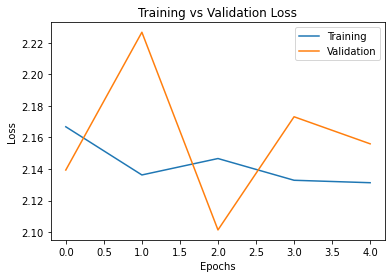

In [59]:
# Plotting Validation Accuracies Vs Train Accuracies on Epochs
plt.plot(range(n_epochs),trainLoss, label="Training")
plt.plot(range(n_epochs),valLoss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [ ]:
from torchvision.models.resnet import resnet34
#Calculate Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = resnet34(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1', ' 2', ' 3', '4','5','6','7','8','9','10','11','12','13','14')

# Build confusion matrix
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),
                              display_labels=classes)
fig,ax = plt.subplots(figSize=(13,13))
plt.title("Confusion Matrix ResNet 34 (15-Classes)")
disp.plot(ax=ax)

plt.show()

NameError: ignored

In [ ]:
#Precision Calculation and Recall calculation
from sklearn.metrics import precision_score, recall_score,f1_score

print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))
print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

0.5571428571428572